In [1]:
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import *
from testCases import *
import sklearn
import sklearn.datasets
import scipy.io

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0,4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

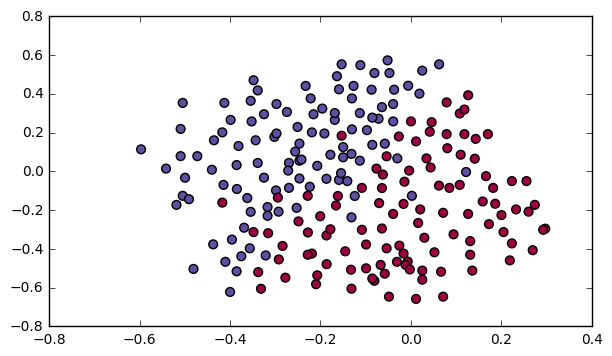

In [2]:
train_X , train_Y , test_X , test_Y = load_2D_dataset()

In [3]:
# model containing both regularization and drop outs
def model(X,Y , learning_rate=0.3 , num_iter=30000 , print_cost=True, lambd = 0 , keep_prob =1):
    grads={}
    costs=[]
    m=X.shape[1]
    layers_dims = [X.shape[0] , 20,3,1] #two layer nn linear->relu->linear->relu->linear->sigmoid
    
    parameters = initialize_parameters(layers_dims)
    
    for i in range(0,num_iter):
        if keep_prob == 1:
            a3 , cache = forward_propagation(X , parameters)
        elif keep_prob < 1:
            a3 , cache = forward_propagation_with_dropout(X , parameters , keep_prob)
        
        if lambd == 0:
            cost  = compute_cost(a3,Y)
        else:
            cost = compute_cost_with_regularization(a3,Y,parameters,lambd)
        
        assert(lambd==0 or keep_prob ==1)
        
        if lambd == 0 and keep_prob ==1:
            grads = backward_propagation(X,Y,cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X,Y,cache , lambd)
        elif keep_prob <1:
            grads = backward_propagation_with_dropout(X,Y,cache,keep_prob)
            
        parameters = update_parameters(parameters , grads , learning_rate)
        
        #usual printing cost function
        if print_cost and i%10000==0:
            print("cost after iteration {}:{}".format(i,cost))
        if print_cost and i%1000 ==0:
            costs.append(cost)
            
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations per thousand')
    plt.title('Learning rate=' + str(learning_rate))
    plt.show()
    
    return parameters

cost after iteration 0:0.6557412523481002
cost after iteration 10000:0.16329987525724213
cost after iteration 20000:0.13851642423253263


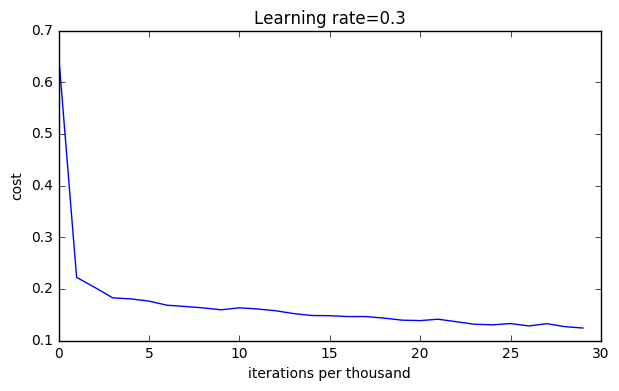

On the training set: 
Accuracy: 0.947867298578
On the test set: 
Accuracy: 0.915


In [4]:
#lets train without regularization or drop outs

parameters = model(train_X , train_Y)
print("On the training set: ")
predictions_train = predict(train_X , train_Y , parameters)
print("On the test set: ")
pridictions_test = predict(test_X , test_Y , parameters)

/home/devendra/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/devendra/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


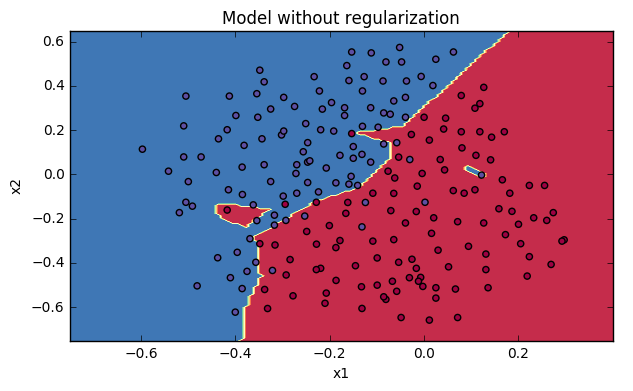

In [5]:
# lets see how decision boundary is

plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters,x.T) , train_X , train_Y)

The non-regularized model is obviously overfitting the training set. It is fitting the noisy points! Lets now look at two techniques to reduce overfitting.

## L2 Regularization

The standard way to avoid overfitting is called **L2 regularization**. It consists of appropriately modifying your cost function, from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

Let's modify your cost and observe the consequences.

**Exercise**: Implement `compute_cost_with_regularization()` which computes the cost given by formula (2). To calculate $\sum\limits_k\sum\limits_j W_{k,j}^{[l]2}$  , use :
```python
np.sum(np.square(Wl))
```
Note that you have to do this for $W^{[1]}$, $W^{[2]}$ and $W^{[3]}$, then sum the three terms and multiply by $ \frac{1}{m} \frac{\lambda}{2} $.

In [6]:
def compute_cost_with_regularization(A3,Y , parameters,lambd):
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3,Y)
    
    L2_regularization_cost = 1/m*lambd/2*(np.sum(np.square(W1))+np.sum(np.square(W2))+np.sum(np.square(W3)))
    
    final_cost = cross_entropy_cost + L2_regularization_cost
    
    return final_cost

In [7]:
A3 , Y_assess , parameters = compute_cost_with_regularization_test_case()
print("cost = "+ str(compute_cost_with_regularization(A3,Y_assess , parameters , lambd=0.1)))

cost = 1.78648594516


Implement the changes needed in backward propagation to take into account regularization. The changes only concern dW1, dW2 and dW3. For each, you have to add the regularization term's gradient ($\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2) = \frac{\lambda}{m} W$).

In [8]:
def backward_propagation_with_regularization(X , Y , cache , lambd):
    m = X.shape[1]
    (Z1,A1,W1,b1,Z2,A2,W2,b2,Z3,A3,W3,b3) = cache
    
    dZ3 = A3 - Y
    
    dW3 = 1./m*np.dot(dZ3 , A2.T) + lambd/m*W3 #change from regular backprop
    
    db3 = 1./m * np.sum(dZ3 , axis=1 , keepdims = True)
    
    dA2 = np.dot(W3.T , dZ3)
    dZ2 = np.multiply(dA2 , np.int64(A2>0))
    
    dW2 = 1./m*np.dot(dZ2 , A1.T) + lambd/m*W2 #change from regular backprop
    
    db2 = 1./m*np.sum(dZ2 , axis=1 , keepdims = True)
    
    dA1 = np.dot(W2.T , dZ2)
    dZ1 = np.multiply(dA1 , np.int64(A1>0))
    
    dW1 = 1./m*np.dot(dZ1 , X.T) + lambd/m*W1 #change from regular backprop
    
    db1 = 1./m*np.sum(dZ1 , axis=1 , keepdims=True)
    
    gradients = {
        "dZ3":dZ3,
        "dW3":dW3,
        "db3":db3,
        "dA2":dA2,
        "dZ2":dZ2,
        "dW2":dW2,
        "db2":db2,
        "dA1":dA1,
        "dZ1":dZ1,
        "dW1":dW1,
        "db1":db1
    }
    return gradients

In [9]:
X_assess , Y_assess , cache = backward_propagation_with_regularization_test_case()
grads = backward_propagation_with_regularization(X_assess , Y_assess , cache ,lambd=0.7 )
print("dW1 = " + str(grads["dW1"]))
print("dW2 = " + str(grads["dW2"]))
print("dW3 = " + str(grads["dW3"]))

dW1 = [[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = [[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = [[-1.77691347 -0.11832879 -0.09397446]]


cost after iteration 0:0.6974484493131264
cost after iteration 10000:0.2684918873282239
cost after iteration 20000:0.26809163371273015


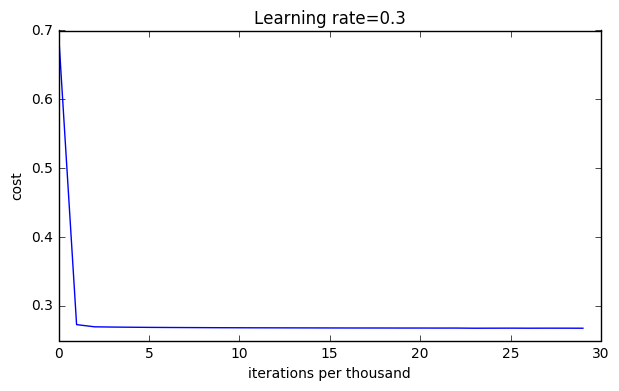

On the train set: 
Accuracy: 0.938388625592
On the test set: 
Accuracy: 0.93


In [10]:
parameters = model(train_X , train_Y , lambd=0.7)
print("On the train set: ")
predictions_train = predict(train_X , train_Y,parameters)
print("On the test set: ")
predictions_test = predict(test_X , test_Y , parameters)


/home/devendra/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/devendra/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


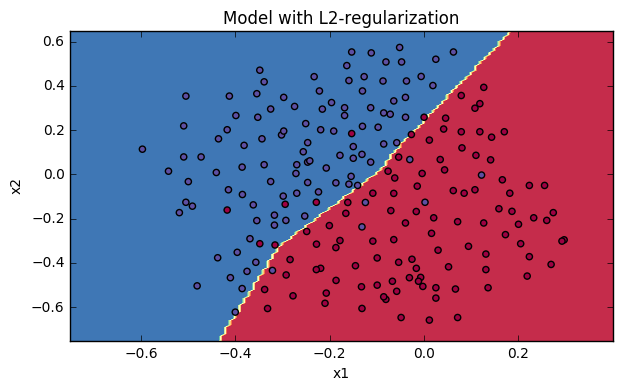

In [11]:
#seeing the boundary of separation
plt.title('Model with L2-regularization')
axes = plt.gca()
axes.set_xlim([-0.75 , 0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters,x.T),train_X , train_Y)

In [12]:
#Now dropout main thing in forward propagation
def forward_propagation_with_dropout(X , parameters , keep_prob=0.5):
    np.random.seed(1)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = np.dot(W1,X) + b1
    A1=relu(Z1)
    
    D1 = np.random.rand(A1.shape[0] , A1.shape[1])
    D1 = D1<keep_prob
    A1 = np.multiply(A1,D1)
    A1 = A1/keep_prob
    
    Z2 = np.dot(W2 , A1) + b2
    A2 = relu(Z2)
    D2 = np.random.rand(A2.shape[0],A2.shape[1])
    D2 = D2<keep_prob
    A2 = np.multiply(A2,D2)
    A2 = A2/keep_prob
    
    Z3 = np.dot(W3,A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1,D1,A1,W1,b1,Z2,D2,A2,W2,b2,Z3,A3,W3,b3)
    
    return A3,cache

In [13]:
X_assess , parameters = forward_propagation_with_dropout_test_case()
A3 , cache = forward_propagation_with_dropout(X_assess , parameters , keep_prob=0.7)
print("A3 = "+ str(A3))

A3 = [[ 0.36974721  0.00305176  0.04565099  0.49683389  0.36974721]]


In [25]:
#backpropagation for drop out
#Apply same D1 D2 to dA1 dA2 so that result will effect dW1, dW2 as well
def backward_propagation_with_dropout(X,Y,cache,keep_prob):
    m = X.shape[1]
    (Z1,D1,A1,W1,b1,Z2,D2,A2,W2,b2,Z3,A3,W3,b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m*np.dot(dZ3 , A2.T)
    db3 = 1./m*np.sum(dZ3,axis=1,keepdims=True)
    dA2 = np.dot(W3.T , dZ3)
    
    dA2 = dA2*D2
    dA2 = dA2/keep_prob
    
    dZ2 = np.multiply(dA2 , np.int64(A2>0))
    dW2 = 1./m*np.dot(dZ2 , A1.T)
    db2 = 1./m*np.sum(dZ2 , axis=1 , keepdims=True)
    dA1 = np.dot(W2.T , dZ2)
    
    dA1 = dA1*D1
    dA1 = dA1 / keep_prob
    
    dZ1 = np.multiply(dA1 , np.int64(A1>0))
    dW1 = 1./m*np.dot(dZ1 , X.T)
    db1 = 1./m*np.sum(dZ1 , axis=1 , keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    return gradients
    

In [26]:
X_assess , Y_assess , cache = backward_propagation_with_dropout_test_case()
grads = backward_propagation_with_dropout(X_assess , Y_assess , cache , keep_prob=0.8)
print("dA1 = "+str(grads["dA1"]))
print("dA2 = "+str(grads["dA2"]))

dA1 = [[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = [[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


cost after iteration 0:0.6543912405149825


/home/devendra/Devendra_study/deep_learning_coursera/course2/week1/Regularization/reg_utils.py:236: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
/home/devendra/Devendra_study/deep_learning_coursera/course2/week1/Regularization/reg_utils.py:236: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


cost after iteration 10000:0.06101698657490562
cost after iteration 20000:0.060582435798513114


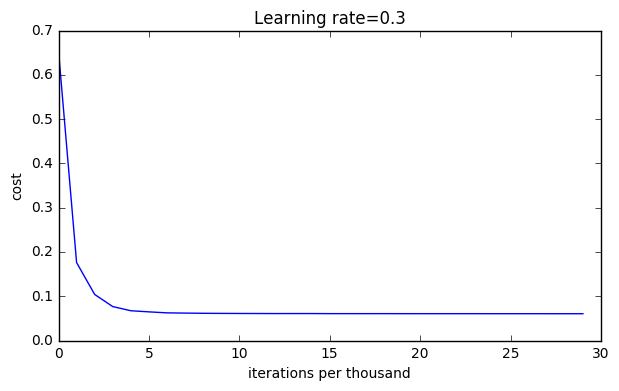

On the train set:
Accuracy: 0.928909952607
On the test set:
Accuracy: 0.95


In [28]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

/home/devendra/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/devendra/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


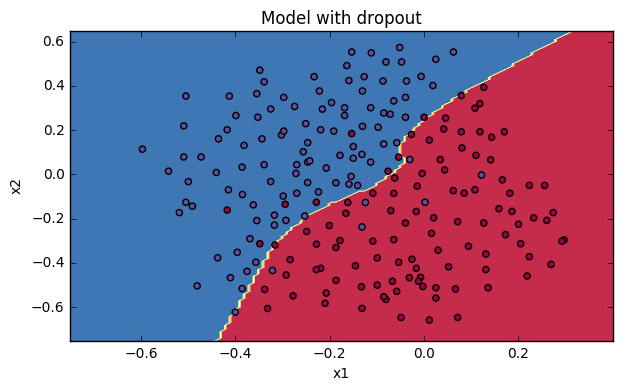

In [31]:
#lets plot boundary
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters , x.T) , train_X , train_Y)

**Here are the results of our three models**: 

<table> 
    <tr>
        <td>
        **model**
        </td>
        <td>
        **train accuracy**
        </td>
        <td>
        **test accuracy**
        </td>

    </tr>
        <td>
        3-layer NN without regularization
        </td>
        <td>
        95%
        </td>
        <td>
        91.5%
        </td>
    <tr>
        <td>
        3-layer NN with L2-regularization
        </td>
        <td>
        94%
        </td>
        <td>
        93%
        </td>
    </tr>
    <tr>
        <td>
        3-layer NN with dropout
        </td>
        <td>
        93%
        </td>
        <td>
        95%
        </td>
    </tr>
</table> 